## Supervised Classification for Underserved Regions

### Introduction

This notebook focuses on using **Random Forest** and **Logistic Regression** models to classify regions as **underserved** based on various Medicare Durable Medical Equipment, Prosthetics, Orthotics, and Supplies (DMEPOS) service characteristics. The goal is to identify regions with **higher supplier service volumes** and **Medicare payments**, potentially indicating inefficiencies or areas needing more resources or support.

### Supervised Classification Overview:
Supervised classification involves training a model on labeled data to predict the class or category of new, unseen data. In this context, the task is to classify regions as **underserved** or **not underserved** based on service volumes, charges, and other relevant features.

The **underserved region** variable is created using the following approach:
- **High Underserved**: Classified as **High Underserved** if both **high charges** and **low service volumes** conditions are met.
- **Low Underserved**: Classified as **Low Underserved** if either **high charges** or **low service volumes** conditions are met.
- **Not Underserved**: Classified as **Not Underserved** if neither condition is met.

### Defining High Charges and Low Service Volumes:
The thresholds for **high charges** and **low service volumes** are based on percentiles of the data:
- **High Charges**: Values above the **95th percentile** of the **average supplier submitted charges** (`Avg_Suplr_Sbmtd_Chrg`).
- **Low Service Volumes**: Values below the **5th percentile** of the **total supplier services** (`Tot_Suplr_Srvcs`).

Regions are flagged based on these thresholds, and the resulting `underserved_level` variable serves as the target for classification.

### Feature Selection Using PCA:
To reduce dimensionality and focus on the most relevant features for classification, **Principal Component Analysis (PCA)** is performed. PCA reduces the number of features while retaining the most significant variance in the data. The selected features for classification include:
- `Tot_Suplrs`: Total number of suppliers
- `Tot_Suplr_Benes`: Total number of beneficiaries
- `Tot_Suplr_Srvcs`: Total number of services provided by suppliers
- `Avg_Suplr_Sbmtd_Chrg`: Average supplier submitted charges
- `Avg_Suplr_Mdcr_Alowd_Amt`: Average Medicare allowed amount
- `Avg_Suplr_Mdcr_Pymt_Amt`: Average Medicare payment amount

These features were selected for their contribution to explaining the variance in the dataset and for improving model efficiency and stability by reducing overfitting.

### Model Justification for Underserved Classification:
The **underserved region** classification is treated as a binary outcome, where **Not Underserved** is mapped to `0` and **Underserved** (comprising both "Low Underserved" and "High Underserved") is mapped to `1`. This simplification was chosen due to computational challenges and time constraints with multi-class regression. The binary classification enables clearer identification of regions that require additional resources or policy interventions.

### Models Used:
Two models are employed to classify regions:
1. **Random Forest Classifier**:
   - An ensemble learning method that builds multiple decision trees and combines their predictions. Random Forest can handle high-dimensional data and capture complex relationships between features like service volumes, charges, and more. It also provides insights into **feature importance**, identifying which variables most influence classification.
   
2. **Logistic Regression**:
   - A binary classification model that estimates the probability of a region being underserved using a linear combination of input features. Despite being simpler, Logistic Regression provides clear insights into the **relationship between input variables** and the target classification.

### Research Question:
The research question addressed in this notebook is:
- **RQ2: Do certain regions consistently show higher supplier service volumes and Medicare payments, and are underserved areas disproportionately charged higher rates during specific periods, which could support targeted policy interventions?**

The goal is to use machine learning models to classify regions as underserved, enabling **data-driven policy interventions** and more effective resource allocation in the Medicare system.

### Goals:
- **Train and Evaluate Models**: Train both the Random Forest and Logistic Regression models to classify regions as underserved or not based on historical data.
- **Assess Model Performance**: Evaluate model performance using metrics like accuracy, precision, recall, F1-score, and AUC to determine the models' effectiveness in identifying underserved regions.
- **Interpret Results**: Analyze the models' predictions to understand which features (e.g., service volumes, charges) are most influential in classifying regions as underserved.

### Time-Series Split Cross-Validation:
Given the time-series nature of the data, a **time-series split cross-validation** approach was employed. This method ensures that models are tested on future, unseen data points, avoiding data leakage and providing more reliable performance assessments. The data is split by year, with training data from earlier years and testing data from later years.

### Model Performance Metrics
The following metrics were used to evaluate model performance for both the Random Forest and Logistic Regression models:

1. **Cross-Validation Scores**: Includes **fit_time**, **score_time**, **test_accuracy**, **test_precision**, and **test_recall**. These metrics are evaluated during cross-validation, where the data is split into training and validation sets to assess the model’s performance across different subsets.

2. **AUC (Area Under the Curve)**: Measures the model's ability to distinguish between the classes. A higher AUC indicates better performance in classifying regions as underserved or not.

3. **Memory Usage during Training**: Indicates the memory consumed during model training for both algorithms.

4. **Matthews Correlation Coefficient (MCC)**: Measures the correlation between predicted and actual values, with a higher MCC indicating better classification performance.

5. **Brier Score**: Evaluates the calibration of probabilistic predictions, with a lower Brier score indicating better calibration.

### Model Comparison
The models were evaluated in three configurations:
1. **Original Models (without hyperparameter tuning)**: Baseline models trained and evaluated without adjusting hyperparameters.
2. **Models with Hyperparameter-Tuned**: Models optimized with hyperparameter tuning to improve generalization and performance.
3. **Models Using Only 2 Selected Features**: A reduced feature set was tested based on Feature Importance Analysis to evaluate efficiency and stability with fewer variables.

### Conclusion
This notebook presents a detailed approach for classifying underserved regions using **Random Forest** and **Logistic Regression** models. The simplified binary classification enables targeted policy interventions, helping to identify areas in need of more resources. By evaluating model performance with multiple metrics and comparing different configurations, the notebook aims to provide actionable insights into **Medicare DMEPOS** service data and support data-driven decision-making for improving healthcare accessibility.


In [14]:
# Set the working directory to the working folder 
import os
os.chdir('/Users/rozani/Desktop/capstone')


In [15]:
# Filter out warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# Importing necessary libraries for data manipulation, modeling, and evaluation
import numpy as np
import pandas as pd

# Importing classifiers for model building
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.linear_model import LogisticRegression  # Logistic Regression model

# Importing evaluation metrics for model performance assessment
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score  # Evaluation metrics
from sklearn.metrics import classification_report  # Reporting tools for classification results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For confusion matrix display
from sklearn.metrics import matthews_corrcoef  # Matthews correlation coefficient for classification performance
from sklearn.metrics import brier_score_loss  # Brier score for evaluating probabilistic predictions

# TimeSeriesSplit for time-series cross-validation, cross_validate for model evaluation
from sklearn.model_selection import TimeSeriesSplit  # Cross-validation for time-series data
from sklearn.model_selection import cross_validate  # Function for cross-validation

# For generating random integers (often used in hyperparameter tuning)
from scipy.stats import randint

# For monitoring memory usage during model training
from memory_profiler import memory_usage  # Memory usage profiling during training

# Importing plotting libraries for data visualization
import matplotlib.pyplot as plt  # General plotting library
import seaborn as sns  # Advanced plotting library

In [16]:
# Load the training data
train_data = pd.read_csv('combined_data.csv')
print(train_data.columns)

# Load the test data
test_data = pd.read_csv('test_data.csv')
print(test_data.columns)


Index(['Rfrg_Prvdr_Geo_Lvl', 'Rfrg_Prvdr_Geo_Cd', 'Rfrg_Prvdr_Geo_Desc',
       'RBCS_Lvl', 'RBCS_Id', 'RBCS_Desc', 'HCPCS_Cd', 'HCPCS_Desc',
       'Suplr_Rentl_Ind', 'Tot_Rfrg_Prvdrs', 'Tot_Suplrs', 'Tot_Suplr_Benes',
       'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg',
       'Avg_Suplr_Mdcr_Alowd_Amt', 'Avg_Suplr_Mdcr_Pymt_Amt',
       'Avg_Suplr_Mdcr_Stdzd_Amt', 'Year', 'high_charges',
       'low_service_volumes', 'is_underserved', 'underserved_level'],
      dtype='object')
Index(['Rfrg_Prvdr_Geo_Lvl', 'Rfrg_Prvdr_Geo_Cd', 'Rfrg_Prvdr_Geo_Desc',
       'RBCS_Lvl', 'RBCS_Id', 'RBCS_Desc', 'HCPCS_Cd', 'HCPCS_Desc',
       'Suplr_Rentl_Ind', 'Tot_Rfrg_Prvdrs', 'Tot_Suplrs', 'Tot_Suplr_Benes',
       'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg',
       'Avg_Suplr_Mdcr_Alowd_Amt', 'Avg_Suplr_Mdcr_Pymt_Amt',
       'Avg_Suplr_Mdcr_Stdzd_Amt', 'Year', 'high_charges',
       'low_service_volumes', 'is_underserved', 'underserved_level'],
      dtype='object'

## Mapping Underserved Regions to Binary Labels and Plotting Trends

In [17]:
# Manually map the categories to integers
mapping = {'Not Underserved': 0, 'Low Underserved': 1, 'High Underserved': 1}

# Apply the mapping to both train_data and test_data
train_data['underserved_level'] = train_data['underserved_level'].map(mapping)
test_data['underserved_level'] = test_data['underserved_level'].map(mapping)

# Verify the result (for both train_data and test_data)
print("Train Data Underserved Level Counts:")
print(train_data['underserved_level'].value_counts())

print("Test Data Underserved Level Counts:")
print(test_data['underserved_level'].value_counts())


Train Data Underserved Level Counts:
underserved_level
0    265096
1     29956
Name: count, dtype: int64
Test Data Underserved Level Counts:
underserved_level
0    71473
1     7923
Name: count, dtype: int64


### Distribution of Underserved Regions by Geographic Description

<Figure size 1400x800 with 0 Axes>

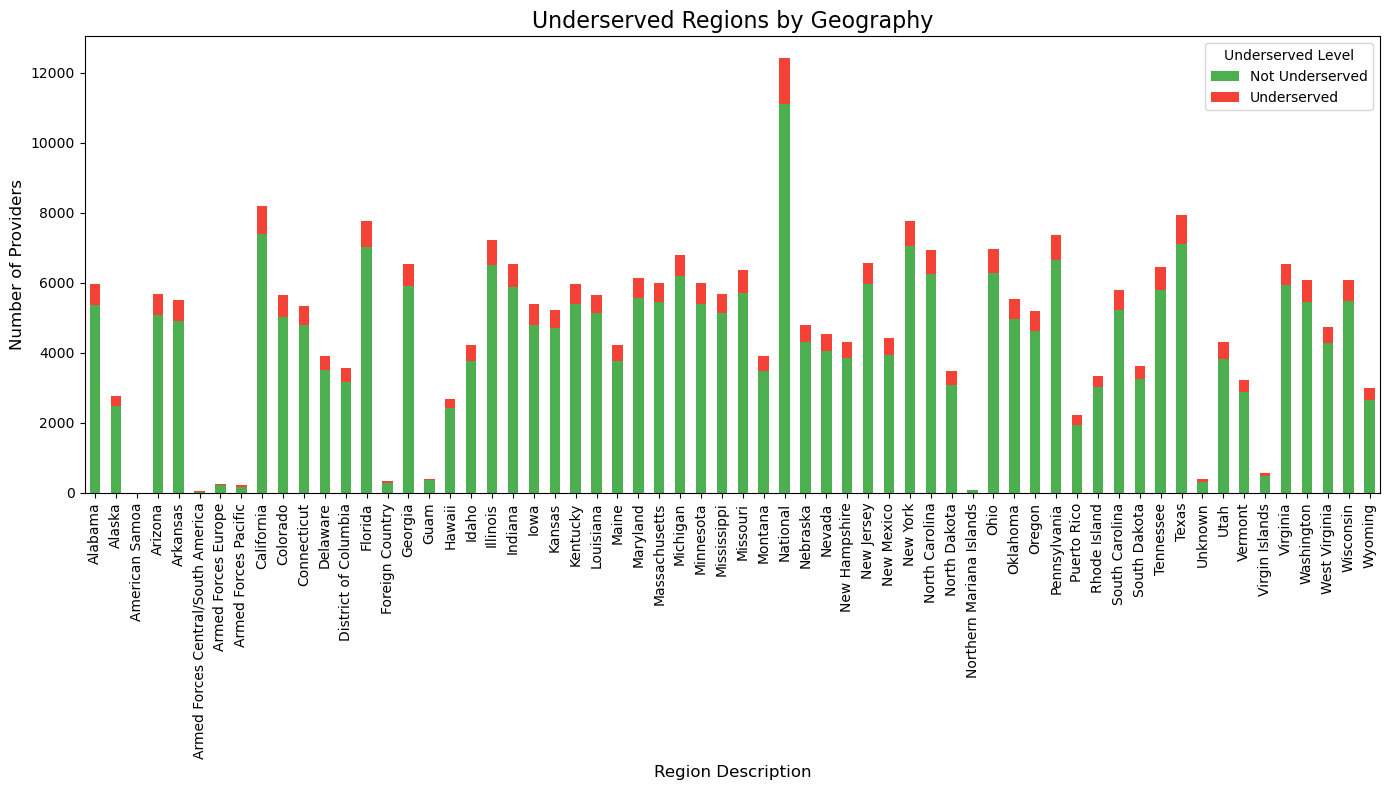

In [19]:
# Visualize the count of underserved regions by 'Rfrg_Prvdr_Geo_Desc' (region description) and 'underserved_level'
plt.figure(figsize=(14, 8))

# Group by 'Rfrg_Prvdr_Geo_Desc' and 'underserved_level', then count the number of occurrences
region_underserved = train_data.groupby(['Rfrg_Prvdr_Geo_Desc', 'underserved_level']).size().unstack()

# Plot the stacked bar plot
region_underserved.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#4CAF50', '#F44336'])

# Title and labels
plt.title('Underserved Regions by Geography', fontsize=16)
plt.xlabel('Region Description', fontsize=12)
plt.ylabel('Number of Providers', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Underserved Level', labels=['Not Underserved', 'Underserved'], loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


### Temporal Trends in Supplier Metrics by Underserved Level

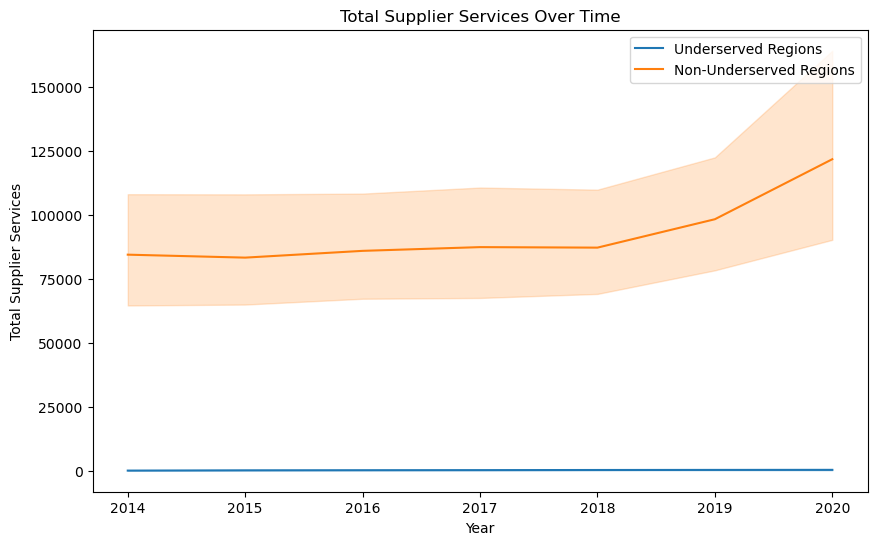

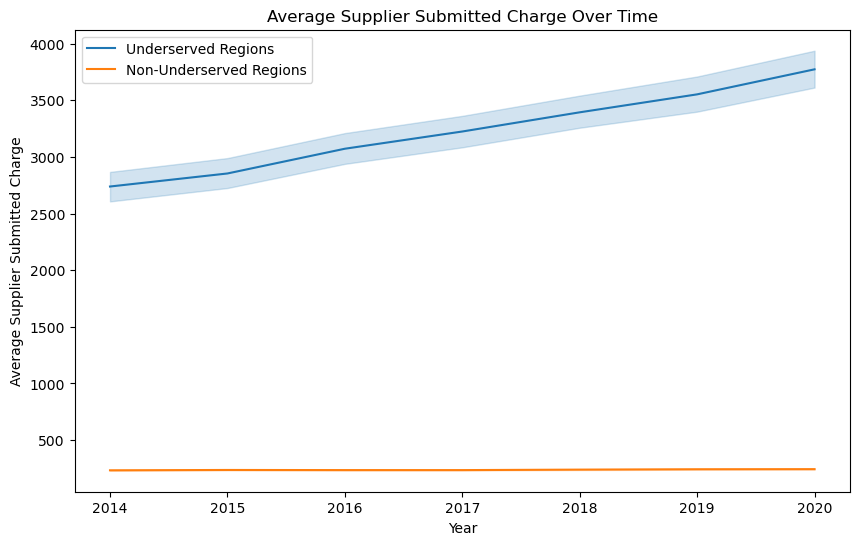

In [20]:
# Split data by underserved level
underserved_data = train_data[train_data['underserved_level'] == 1]
non_underserved_data = train_data[train_data['underserved_level'] == 0]

# Plot Total Supplier Services Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Tot_Suplr_Srvcs', data=underserved_data, label='Underserved Regions')
sns.lineplot(x='Year', y='Tot_Suplr_Srvcs', data=non_underserved_data, label='Non-Underserved Regions')
plt.title('Total Supplier Services Over Time')
plt.xlabel('Year')
plt.ylabel('Total Supplier Services')
plt.legend()
plt.show()

# Plot Average Supplier Submitted Charge Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Avg_Suplr_Sbmtd_Chrg', data=underserved_data, label='Underserved Regions')
sns.lineplot(x='Year', y='Avg_Suplr_Sbmtd_Chrg', data=non_underserved_data, label='Non-Underserved Regions')
plt.title('Average Supplier Submitted Charge Over Time')
plt.xlabel('Year')
plt.ylabel('Average Supplier Submitted Charge')
plt.legend()
plt.show()

## Functions for Model Evaluation and Memory Usage Tracking

In [102]:
# Function to compute AUC
def compute_auc(model, X, y):
    """
    Computes the AUC for a given model on provided data.

    Parameters:
    model : fitted model with `predict_proba` method
    X : input features
    y : true labels

    Returns:
    auc_score : float
    """
    y_prob = model.predict_proba(X)[:, 1]  # probabilities for the positive class (1)
    auc_score = roc_auc_score(y, y_prob)
    return auc_score


# Function for Cross-validation
def perform_cross_validation(classifier, X, y, cv, scoring_metrics=['accuracy', 'precision', 'recall']):
    """
    Cross-validates a given classifier and returns a DataFrame with cross-validation scores.

    Parameters:
    classifier : model to evaluate
    X : input features
    y : output labels
    cv : cross-validation splitter (e.g., TimeSeriesSplit)
    scoring_metrics : list of scoring metrics to evaluate

    Returns:
    scores_df : DataFrame containing cross-validation scores
    """
    scores = cross_validate(
        estimator=classifier,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring_metrics
    )
    
    # Convert scores dictionary to DataFrame for better visualization
    scores_df = pd.DataFrame(scores).round(4)
    return scores_df


# Function to track memory usage during fitting of both models
def track_memory_usage(X_train, y_train, rfclassifier, logregclassifier):
    """
    Tracks memory usage during the training of both Random Forest and Logistic Regression models.
    
    Parameters:
    X_train : Input features for training
    y_train : True labels for training
    rfclassifier : RandomForestClassifier model
    logregclassifier : LogisticRegression model
    
    Returns:
    mem_usage_rf : Memory usage during Random Forest training
    mem_usage_logreg : Memory usage during Logistic Regression training
    """
    
    # Define a function to track memory usage during fitting for Random Forest
    def fit_rf_and_track_memory():
        rfclassifier.fit(X_train, y_train)
    
    # Measure memory usage during fitting for Random Forest
    mem_usage_rf = memory_usage(fit_rf_and_track_memory)
    
    # Define a function to track memory usage during fitting for Logistic Regression
    def fit_logreg_and_track_memory():
        logregclassifier.fit(X_train, y_train)
    
    # Measure memory usage during fitting for Logistic Regression
    mem_usage_logreg = memory_usage(fit_logreg_and_track_memory)
    
    # Return the memory usage for each model
    return max(mem_usage_rf), max(mem_usage_logreg)


## Model Evaluation and Memory Usage: Random Forest vs Logistic Regression

In [115]:
# Define the features and labels for training data
features = ['Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Srvcs',
            'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt', 
            'Avg_Suplr_Mdcr_Pymt_Amt']

X_train = train_data[features]
y_train = train_data['underserved_level']

# Define the time-series split
tscv = TimeSeriesSplit(n_splits=5)


# Initialize the classifiers
rfclassifier = RandomForestClassifier(random_state= 22) 
logregclassifier = LogisticRegression(random_state= 22) 

# Fit the models on the training data and compute AUC
rfclassifier.fit(X_train, y_train)
logregclassifier.fit(X_train, y_train)

LogisticRegression(random_state=22)

In [116]:
# memory usage
mem_usage_rf, mem_usage_logreg = track_memory_usage(X_train, y_train, rfclassifier, logregclassifier)

# Compute AUC on the training data
rf_auc = compute_auc(rfclassifier, X_train, y_train)
logreg_auc = compute_auc(logregclassifier, X_train, y_train)

# Perform cross-validation for Random Forest and Logistic Regression
rf_scores_df = perform_cross_validation(rfclassifier, X_train, y_train, tscv)
logreg_scores_df = perform_cross_validation(logregclassifier, X_train, y_train, tscv)

# Display the cross-validation results
print("Random Forest Cross-Validation Scores (Training Data):\n", rf_scores_df)
print(f"Random Forest AUC (Training Data): {rf_auc:.4f}")
print(f"Memory usage during Random Forest training: {mem_usage_rf} MB")

print("\nLogistic Regression Cross-Validation Scores (Training Data):\n", logreg_scores_df)
print(f"Logistic Regression AUC (Training Data): {logreg_auc:.4f}")
print(f"Memory usage during Logistic Regression training: {mem_usage_logreg} MB")

Random Forest Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    4.6633      0.2961            1.0          0.9998          1.0
1    8.6485      0.2744            1.0          0.9998          1.0
2   11.6824      0.4875            1.0          0.9996          1.0
3   16.0001      0.2764            1.0          1.0000          1.0
4   22.0594      0.2488            1.0          1.0000          1.0
Random Forest AUC (Training Data): 1.0000
Memory usage during Random Forest training: 421.3515625 MB

Logistic Regression Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.3587      0.0351         0.9347          0.8606       0.4731
1    0.5951      0.0337         0.9400          0.9023       0.4780
2    1.5831      0.0464         0.9410          0.8849       0.4709
3    2.1514      0.0445         0.9391          0.8981       0.5422
4    2.0353      0.0391         

### Model Performance on Training Data: Classification Reports for Random Forest and Logistic Regression

In [117]:
# Print classification reports (on training data)
rf_train_pred = rfclassifier.predict(X_train)
logreg_train_pred = logregclassifier.predict(X_train)

print("Random Forest Classification Report (Training Data):")
print(classification_report(y_train, rf_train_pred))

print("\nLogistic Regression Classification Report (Training Data):")
print(classification_report(y_train, logreg_train_pred))


Random Forest Classification Report (Training Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    265096
           1       1.00      1.00      1.00     29956

    accuracy                           1.00    295052
   macro avg       1.00      1.00      1.00    295052
weighted avg       1.00      1.00      1.00    295052


Logistic Regression Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    265096
           1       0.90      0.49      0.63     29956

    accuracy                           0.94    295052
   macro avg       0.92      0.74      0.80    295052
weighted avg       0.94      0.94      0.93    295052



### Confusion Matrices: Random Forest vs Logistic Regression on Training Datan 

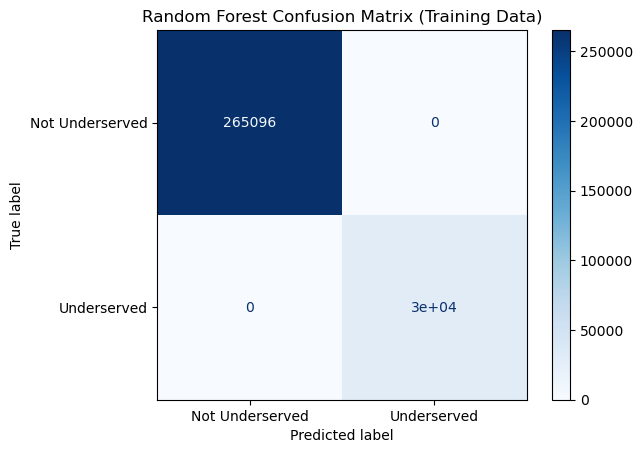

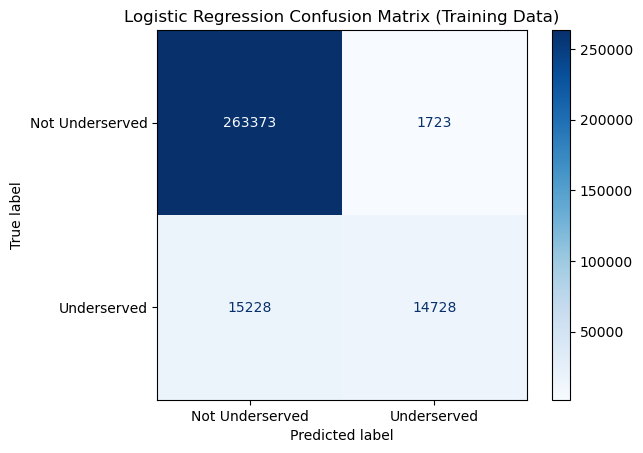

In [119]:
# Generate predictions on the training set for both models
rf_train_pred = rfclassifier.predict(X_train)
logreg_train_pred = logregclassifier.predict(X_train)

# Create and display the confusion matrix for Random Forest on training data
rf_cm_train = confusion_matrix(y_train, rf_train_pred)
rf_cm_display_train = ConfusionMatrixDisplay(confusion_matrix=rf_cm_train, display_labels=["Not Underserved", "Underserved"])
rf_cm_display_train.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (Training Data)")
plt.show()

# Create and display the confusion matrix for Logistic Regression on training data
logreg_cm_train = confusion_matrix(y_train, logreg_train_pred)
logreg_cm_display_train = ConfusionMatrixDisplay(confusion_matrix=logreg_cm_train, display_labels=["Not Underserved", "Underserved"])
logreg_cm_display_train.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix (Training Data)")
plt.show()


### Matthews Correlation Coefficient (MCC): Random Forest vs Logistic Regression on Training Data

In [120]:
# Calculate MCC for Random Forest on the training data
rf_mcc_train = matthews_corrcoef(y_train, rf_train_pred)
print(f"Random Forest MCC (Training Data): {rf_mcc_train:.4f}")

# Calculate MCC for Logistic Regression on the training data
logreg_mcc_train = matthews_corrcoef(y_train, logreg_train_pred)
print(f"Logistic Regression MCC (Training Data): {logreg_mcc_train:.4f}")


Random Forest MCC (Training Data): 1.0000
Logistic Regression MCC (Training Data): 0.6386


### Brier Score: Random Forest vs Logistic Regression on Training Data

In [121]:
# Get predicted probabilities for the positive class (1) for Random Forest
rf_train_probs = rfclassifier.predict_proba(X_train)[:, 1]
rf_brier_score = brier_score_loss(y_train, rf_train_probs)
print(f"Random Forest Brier Score (Training Data): {rf_brier_score:.4f}")

# Get predicted probabilities for the positive class (1) for Logistic Regression
logreg_train_probs = logregclassifier.predict_proba(X_train)[:, 1]
logreg_brier_score = brier_score_loss(y_train, logreg_train_probs)
print(f"Logistic Regression Brier Score (Training Data): {logreg_brier_score:.4f}")


Random Forest Brier Score (Training Data): 0.0000
Logistic Regression Brier Score (Training Data): 0.0501


# Comparison of Random Forest and Logistic Regression Models: Original Models Evaluation

In [122]:
# Define the features and labels for training and test data
features = ['Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Srvcs',
            'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt', 
            'Avg_Suplr_Mdcr_Pymt_Amt']

# Assign features and labels for training data
X_train = train_data[features]
y_train = train_data['underserved_level']

# Assign features and labels for test data
X_test = test_data[features]
y_test = test_data['underserved_level']


# Define the time-series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the classifiers
rfclassifier = RandomForestClassifier(random_state=22)
logregclassifier = LogisticRegression(random_state=22)

# Fit the models on the training data
rfclassifier.fit(X_train, y_train)
logregclassifier.fit(X_train, y_train)

# Measure memory usage during fitting
mem_usage_rf, mem_usage_logreg = track_memory_usage(X_train, y_train, rfclassifier, logregclassifier)

# Compute AUC on the Training Data
rf_auc_train = compute_auc(rfclassifier, X_train, y_train)
logreg_auc_train = compute_auc(logregclassifier, X_train, y_train)

# Compute AUC on the Test Data
rf_auc_test = compute_auc(rfclassifier, X_test, y_test)
logreg_auc_test = compute_auc(logregclassifier, X_test, y_test)

# Perform cross-validation for Random Forest and Logistic Regression on Training Data
rf_scores_df = perform_cross_validation(rfclassifier, X_train, y_train, tscv)
logreg_scores_df = perform_cross_validation(logregclassifier, X_train, y_train, tscv)

# Display the cross-validation results
print("Random Forest Cross-Validation Scores (Training Data):\n", rf_scores_df)
print(f"Random Forest AUC (Training Data): {rf_auc_train:.4f}")
print(f"Random Forest AUC (Test Data): {rf_auc_test:.4f}")
print(f"Memory usage during Random Forest training: {mem_usage_rf} MB")

print("\nLogistic Regression Cross-Validation Scores (Training Data):\n", logreg_scores_df)
print(f"Logistic Regression AUC (Training Data): {logreg_auc_train:.4f}")
print(f"Logistic Regression AUC (Test Data): {logreg_auc_test:.4f}")
print(f"Memory usage during Logistic Regression training: {mem_usage_logreg} MB")

Random Forest Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    3.3199      0.2606            1.0          0.9998          1.0
1    7.4742      0.4669            1.0          0.9998          1.0
2   11.6353      0.2861            1.0          0.9996          1.0
3   15.3505      0.2724            1.0          1.0000          1.0
4   20.1583      0.2856            1.0          1.0000          1.0
Random Forest AUC (Training Data): 1.0000
Random Forest AUC (Test Data): 0.9976
Memory usage during Random Forest training: 442.19921875 MB

Logistic Regression Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.3335      0.0373         0.9347          0.8606       0.4731
1    0.9924      0.0370         0.9400          0.9023       0.4780
2    1.5954      0.0459         0.9410          0.8849       0.4709
3    2.1121      0.0472         0.9391          0.8981       

### MCC and Brier Score: Original Models

In [123]:
# Predict the test data
rf_test_pred = rfclassifier.predict(X_test)  # Predictions for Random Forest
logreg_test_pred = logregclassifier.predict(X_test)  # Predictions for Logistic Regression

# Calculate MCC for Random Forest on the test data
rf_mcc_test = matthews_corrcoef(y_test, rf_test_pred)
print(f"Random Forest MCC (Test Data): {rf_mcc_test:.4f}")

# Calculate MCC for Logistic Regression on the test data
logreg_mcc_test = matthews_corrcoef(y_test, logreg_test_pred)
print(f"Logistic Regression MCC (Test Data): {logreg_mcc_test:.4f}")

# Get predicted probabilities for the positive class (1) for Random Forest on the test data
rf_test_probs = rfclassifier.predict_proba(X_test)[:, 1]
rf_brier_score = brier_score_loss(y_test, rf_test_probs)
print(f"Random Forest Brier Score (Test Data): {rf_brier_score:.4f}")

# Get predicted probabilities for the positive class (1) for Logistic Regression on the test data
logreg_test_probs = logregclassifier.predict_proba(X_test)[:, 1]
logreg_brier_score = brier_score_loss(y_test, logreg_test_probs)
print(f"Logistic Regression Brier Score (Test Data): {logreg_brier_score:.4f}")

Random Forest MCC (Test Data): 0.9681
Logistic Regression MCC (Test Data): 0.6296
Random Forest Brier Score (Test Data): 0.0059
Logistic Regression Brier Score (Test Data): 0.0495


### Confusion Matrices: Original Models

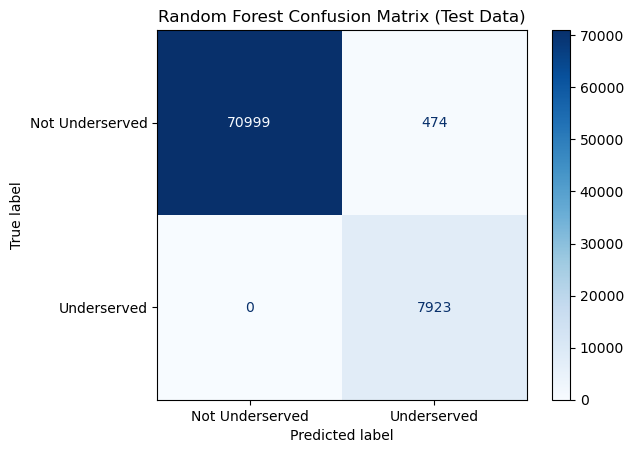

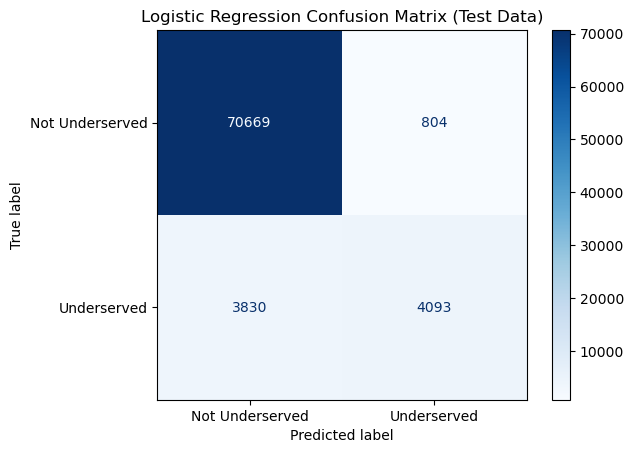

In [124]:
# Get predictions for the test data
rf_test_pred = rfclassifier.predict(X_test)
logreg_test_pred = logregclassifier.predict(X_test)

# Confusion matrix for Random Forest (Test Data)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_test_cm, display_labels=["Not Underserved", "Underserved"])
rf_test_cm_display.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix (Test Data)')
plt.show()

# Confusion matrix for Logistic Regression (Test Data)
logreg_test_cm = confusion_matrix(y_test, logreg_test_pred)
logreg_test_cm_display = ConfusionMatrixDisplay(confusion_matrix=logreg_test_cm, display_labels=["Not Underserved", "Underserved"])
logreg_test_cm_display.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix (Test Data)')
plt.show()


### Hyperparameter Tuning for Random Forest and Logistic Regression using RandomizedSearchCV

In [46]:
# Define features and target labels for training
X_train = train_data[features]  # Features used for training the model
y_train = train_data['underserved_level']  # Target labels indicating underserved levels

# Time-series split with fewer folds for cross-validation
tscv = TimeSeriesSplit(n_splits=3)  # Using 3 splits for cross-validation to save time

# Simplified parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50],          # Reduced options for the number of trees in the forest
    'max_depth': [10, 20],             # Focused on lower depth levels for model simplicity
}

# Initialize Random Forest model with fixed random state to ensure reproducibility
rfclassifier = RandomForestClassifier(random_state=22)

# Set up RandomizedSearchCV for Random Forest using time-series split
random_search_rf = RandomizedSearchCV(
    estimator=rfclassifier,             # Random Forest model
    param_distributions=param_grid_rf,  # Parameters to be searched over
    n_iter=4,                           # Limit the number of combinations to explore (faster search)
    cv=tscv,                            # Time-series cross-validation to account for time-based data
    scoring='roc_auc',                  # Scoring metric (ROC AUC for classification)
    n_jobs=4,                           # Parallelize across 4 processors for faster computation
    verbose=1,                          # Verbose output for tracking progress
    random_state=22                     # Random seed for reproducibility
)

# Run the random search on Random Forest
random_search_rf.fit(X_train, y_train)  # Fit the model to training data

# Output the best parameters and best AUC score for Random Forest
print("Best Parameters for Random Forest:", random_search_rf.best_params_)  # Best hyperparameters found
print("Best AUC Score for Random Forest:", random_search_rf.best_score_)  # Best AUC score during search

# Simplified parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.01, 1, 10],    # Limited values for regularization strength (inverse of regularization)
    'penalty': ['l2'],     # Only using 'l2' penalty for Logistic Regression (L2 regularization)
}

# Initialize Logistic Regression model with a higher max_iter for convergence
logregclassifier = LogisticRegression(max_iter=500, random_state=22)  # Increased iterations for model convergence

# Set up RandomizedSearchCV for Logistic Regression with fewer folds
random_search_logreg = RandomizedSearchCV(
    estimator=logregclassifier,          # Logistic Regression model
    param_distributions=param_grid_logreg,  # Parameters to be searched over
    n_iter=3,                            # Limit combinations for faster search
    cv=3,                                # Use 3 folds for cross-validation
    scoring='roc_auc',                   # Scoring metric (ROC AUC for classification)
    n_jobs=4,                            # Parallelize across 4 processors for faster computation
    verbose=1,                           # Verbose output for tracking progress
    random_state=22                      # Random seed for reproducibility
)

# Run the random search on Logistic Regression
random_search_logreg.fit(X_train, y_train)  # Fit the model to training data

# Output the best parameters and best AUC score for Logistic Regression
print("Best Parameters for Logistic Regression:", random_search_logreg.best_params_)  # Best hyperparameters found
print("Best AUC Score for Logistic Regression:", random_search_logreg.best_score_)  # Best AUC score during search



Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NU

Best Parameters for Random Forest: {'n_estimators': 50, 'max_depth': 20}
Best AUC Score for Random Forest: 0.9999999979305768
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters for Logistic Regression: {'penalty': 'l2', 'C': 10}
Best AUC Score for Logistic Regression: 0.9041180603268004


## Comparison of Random Forest and Logistic Regression Models: Hyperparameter-Tuned 

In [126]:
# Define the features and labels for training and test data
features = ['Tot_Suplrs', 'Tot_Suplr_Benes', 'Tot_Suplr_Srvcs',
            'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt', 
            'Avg_Suplr_Mdcr_Pymt_Amt']

# Assign features and labels for training data
X_train = train_data[features]
y_train = train_data['underserved_level']

# Assign features and labels for test data
X_test = test_data[features]
y_test = test_data['underserved_level']

# Define the time-series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the classifiers
# n_estimators: number of trees in the forest, max_depth: Maximum depth of each tree
rfclassifier = RandomForestClassifier(max_depth= 20,n_estimators= 50,random_state=22)
# penalty='l2': Specifies that L2 regularization, C=10: Sets the regularization strength
logregclassifier = LogisticRegression(penalty='l2', C=10, max_iter=1000, random_state=22)

# Fit the models on the training data
rfclassifier.fit(X_train, y_train)
logregclassifier.fit(X_train, y_train)

# Measure memory usage during fitting
mem_usage_rf, mem_usage_logreg = track_memory_usage(X_train, y_train, rfclassifier, logregclassifier)

# Compute AUC on the Training Data
rf_auc_train = compute_auc(rfclassifier, X_train, y_train)
logreg_auc_train = compute_auc(logregclassifier, X_train, y_train)

# Compute AUC on the Test Data
rf_auc_test = compute_auc(rfclassifier, X_test, y_test)
logreg_auc_test = compute_auc(logregclassifier, X_test, y_test)

# Perform cross-validation for Random Forest and Logistic Regression on Training Data
rf_scores_df = perform_cross_validation(rfclassifier, X_train, y_train, tscv)
logreg_scores_df = perform_cross_validation(logregclassifier, X_train, y_train, tscv)

# Display the cross-validation results
print("Random Forest Cross-Validation Scores (Training Data):\n", rf_scores_df)
print(f"Random Forest AUC (Training Data): {rf_auc_train:.4f}")
print(f"Random Forest AUC (Test Data): {rf_auc_test:.4f}")
print(f"Memory usage during Random Forest training: {mem_usage_rf} MB")

print("\nLogistic Regression Cross-Validation Scores (Training Data):\n", logreg_scores_df)
print(f"Logistic Regression AUC (Training Data): {logreg_auc_train:.4f}")
print(f"Logistic Regression AUC (Test Data): {logreg_auc_test:.4f}")
print(f"Memory usage during Logistic Regression training: {mem_usage_logreg} MB")

Random Forest Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    1.6607      0.1548            1.0          0.9998          1.0
1    3.3484      0.1564            1.0          0.9998          1.0
2    6.6079      0.1506            1.0          0.9996          1.0
3    7.4723      0.1520            1.0          1.0000          1.0
4   10.0769      0.1423            1.0          1.0000          1.0
Random Forest AUC (Training Data): 1.0000
Random Forest AUC (Test Data): 0.9972
Memory usage during Random Forest training: 411.74609375 MB

Logistic Regression Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.3867      0.0356         0.9347          0.8606       0.4731
1    0.8647      0.0397         0.9400          0.9023       0.4780
2    1.7927      0.0373         0.9411          0.8859       0.4709
3    3.5591      0.0355         0.9391          0.8979       

In [127]:
# Predict the test data
rf_test_pred = rfclassifier.predict(X_test)  # Predictions for Random Forest
logreg_test_pred = logregclassifier.predict(X_test)  # Predictions for Logistic Regression

# Calculate MCC for Random Forest on the test data
rf_mcc_test = matthews_corrcoef(y_test, rf_test_pred)
print(f"Random Forest MCC (Test Data): {rf_mcc_test:.4f}")

# Calculate MCC for Logistic Regression on the test data
logreg_mcc_test = matthews_corrcoef(y_test, logreg_test_pred)
print(f"Logistic Regression MCC (Test Data): {logreg_mcc_test:.4f}")

# Get predicted probabilities for the positive class (1) for Random Forest on the test data
rf_test_probs = rfclassifier.predict_proba(X_test)[:, 1]
rf_brier_score = brier_score_loss(y_test, rf_test_probs)
print(f"Random Forest Brier Score (Test Data): {rf_brier_score:.4f}")

# Get predicted probabilities for the positive class (1) for Logistic Regression on the test data
logreg_test_probs = logregclassifier.predict_proba(X_test)[:, 1]
logreg_brier_score = brier_score_loss(y_test, logreg_test_probs)
print(f"Logistic Regression Brier Score (Test Data): {logreg_brier_score:.4f}")

Random Forest MCC (Test Data): 0.9681
Logistic Regression MCC (Test Data): 0.6296
Random Forest Brier Score (Test Data): 0.0059
Logistic Regression Brier Score (Test Data): 0.0495


## Feature Importance Analysis

                    Feature  Importance
2           Tot_Suplr_Srvcs    0.479809
3      Avg_Suplr_Sbmtd_Chrg    0.210325
4  Avg_Suplr_Mdcr_Alowd_Amt    0.180106
5   Avg_Suplr_Mdcr_Pymt_Amt    0.088482
1           Tot_Suplr_Benes    0.032163
0                Tot_Suplrs    0.009116


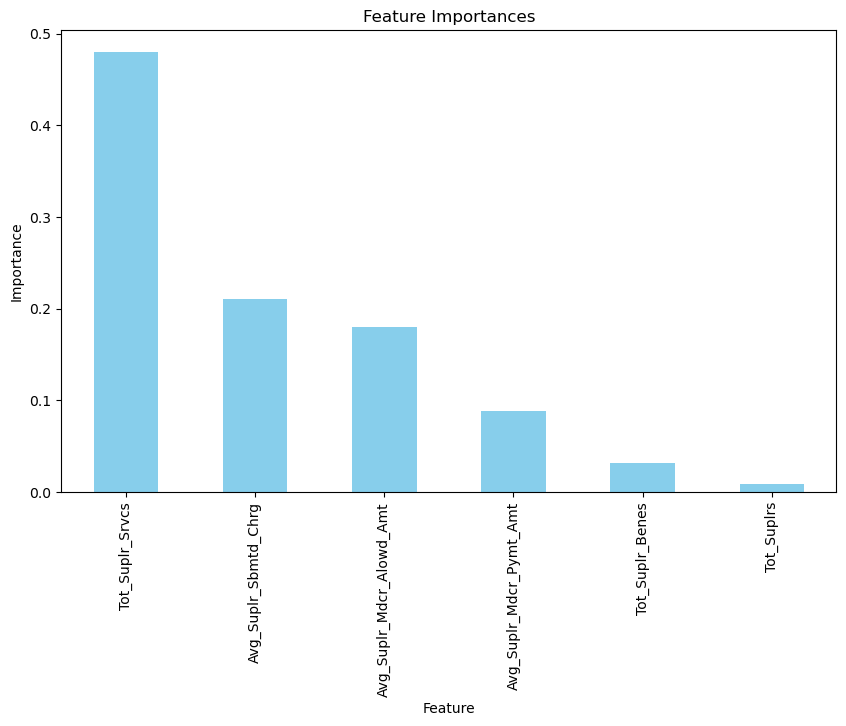

In [128]:
# Extract feature importance
feature_importances = rfclassifier.feature_importances_

# Create a DataFrame to show feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(feature_importance_df)

# Plot the feature importances
feature_importance_df.set_index('Feature')['Importance'].plot.bar(
    title="Feature Importances", color="skyblue", figsize=(10, 6)
)

# Show the plot
plt.ylabel('Importance')
plt.show()

## Comparison of Random Forest and Logistic Regression Models: Selected-Features

In [130]:
# Define the selected features (most important ones based on feature importance)
selected_features = ['Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg']

X_train = train_data[features]
y_train = train_data['underserved_level']

# Assign features and labels for test data
X_test = test_data[features]
y_test = test_data['underserved_level']

# Define the time-series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the classifiers again
rfclassifier = RandomForestClassifier(random_state=22)
logregclassifier = LogisticRegression(max_iter=1000, random_state=22)

# Fit the models with the selected features
rfclassifier.fit(X_train, y_train)
logregclassifier.fit(X_train, y_train)

# Measure memory usage during fitting
mem_usage_rf, mem_usage_logreg = track_memory_usage(X_train, y_train, rfclassifier, logregclassifier)

# Evaluate Random Forest with selected features
rf_selected_pred = rfclassifier.predict(X_test)
rf_selected_auc = roc_auc_score(y_test, rfclassifier.predict_proba(X_test)[:, 1])
rf_selected_accuracy = accuracy_score(y_test, rf_selected_pred)

# Evaluate Logistic Regression with selected features
logreg_selected_pred = logregclassifier.predict(X_test)
logreg_selected_auc = roc_auc_score(y_test, logregclassifier.predict_proba(X_test)[:, 1])
logreg_selected_accuracy = accuracy_score(y_test, logreg_selected_pred)

# Display the cross-validation results
print("Random Forest Cross-Validation Scores (Training Data):\n", rf_scores_df)
print(f"Random Forest AUC (Training Data): {rf_auc_train:.4f}")
print(f"Random Forest AUC (Test Data): {rf_auc_test:.4f}")
print(f"Memory usage during Random Forest training: {mem_usage_rf} MB")

print("\nLogistic Regression Cross-Validation Scores (Training Data):\n", logreg_scores_df)
print(f"Logistic Regression AUC (Training Data): {logreg_auc_train:.4f}")
print(f"Logistic Regression AUC (Test Data): {logreg_auc_test:.4f}")
print(f"Memory usage during Logistic Regression training: {mem_usage_logreg} MB")

Random Forest Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    1.6607      0.1548            1.0          0.9998          1.0
1    3.3484      0.1564            1.0          0.9998          1.0
2    6.6079      0.1506            1.0          0.9996          1.0
3    7.4723      0.1520            1.0          1.0000          1.0
4   10.0769      0.1423            1.0          1.0000          1.0
Random Forest AUC (Training Data): 1.0000
Random Forest AUC (Test Data): 0.9972
Memory usage during Random Forest training: 383.7265625 MB

Logistic Regression Cross-Validation Scores (Training Data):
    fit_time  score_time  test_accuracy  test_precision  test_recall
0    0.3867      0.0356         0.9347          0.8606       0.4731
1    0.8647      0.0397         0.9400          0.9023       0.4780
2    1.7927      0.0373         0.9411          0.8859       0.4709
3    3.5591      0.0355         0.9391          0.8979       0

In [131]:
# Predict the test data
rf_test_pred = rfclassifier.predict(X_test)  # Predictions for Random Forest
logreg_test_pred = logregclassifier.predict(X_test)  # Predictions for Logistic Regression

# Calculate MCC for Random Forest on the test data
rf_mcc_test = matthews_corrcoef(y_test, rf_test_pred)
print(f"Random Forest MCC (Test Data): {rf_mcc_test:.4f}")

# Calculate MCC for Logistic Regression on the test data
logreg_mcc_test = matthews_corrcoef(y_test, logreg_test_pred)
print(f"Logistic Regression MCC (Test Data): {logreg_mcc_test:.4f}")

# Get predicted probabilities for the positive class (1) for Random Forest on the test data
rf_test_probs = rfclassifier.predict_proba(X_test)[:, 1]
rf_brier_score = brier_score_loss(y_test, rf_test_probs)
print(f"Random Forest Brier Score (Test Data): {rf_brier_score:.4f}")

# Get predicted probabilities for the positive class (1) for Logistic Regression on the test data
logreg_test_probs = logregclassifier.predict_proba(X_test)[:, 1]
logreg_brier_score = brier_score_loss(y_test, logreg_test_probs)
print(f"Logistic Regression Brier Score (Test Data): {logreg_brier_score:.4f}")

Random Forest MCC (Test Data): 0.9681
Logistic Regression MCC (Test Data): 0.6296
Random Forest Brier Score (Test Data): 0.0059
Logistic Regression Brier Score (Test Data): 0.0495


### Predicted Underserved Regions by Geographic Description (Test Data)

<Figure size 1400x800 with 0 Axes>

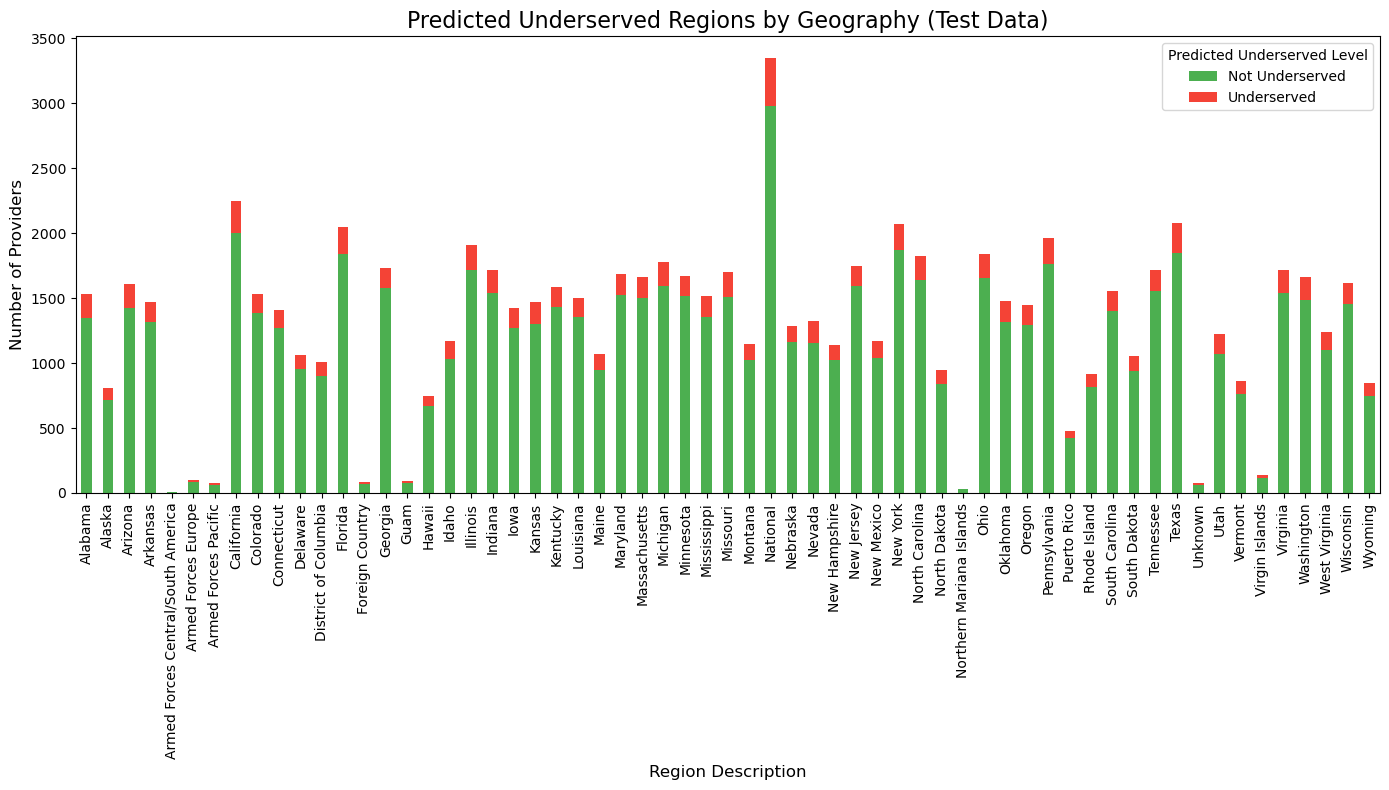

In [141]:
# Predict the underserved level for the test data
test_data['predicted_underserved_level'] = rfclassifier.predict(test_data[features])  # Add the predicted column

# Visualize the predicted underserved levels
plt.figure(figsize=(14, 8))

# Group by 'Rfrg_Prvdr_Geo_Desc' and 'predicted_underserved_level', then count the number of occurrences
region_predicted_underserved = test_data.groupby(['Rfrg_Prvdr_Geo_Desc', 'predicted_underserved_level']).size().unstack()

# Plot the stacked bar plot for predictions
region_predicted_underserved.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#4CAF50', '#F44336'])

# Title and labels
plt.title('Predicted Underserved Regions by Geography (Test Data)', fontsize=16)
plt.xlabel('Region Description', fontsize=12)
plt.ylabel('Number of Providers', fontsize=12)
plt.xticks(rotation=90)

# Adjust the legend if there are only two levels
plt.legend(title='Predicted Underserved Level', labels=['Not Underserved', 'Underserved'], loc='upper right')

# Show plot
plt.tight_layout()
plt.show()
